In [3]:
import pandas as pd 
import math
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [4]:
data=pd.read_csv('brazil.csv') #reads csv file
data.rename(columns={'#NAME?':'Date'},inplace=True) #renames #Name? column to Date
data.drop([0],axis=0,inplace=True) #drops code row
data.fillna(0,inplace=True) #replaces empty columns with 0
data.shape

(5218, 16)

In [5]:
#converts Date object to datetime 
data["Date"] = pd.to_datetime(data["Date"])
data.sort_values(by='Date',inplace=True)

In [6]:
df=data.set_index('Date') 
#converts values into float data type
df = df.astype(float)
#calculates mean of each row - average of stock prices on each day
df['Stock Price']=df.mean(axis=1)
#drops all columns except Stock Price and index column
df.drop(df.loc[:, 'VALE ON':'LOCALIZA RENT A CAR ON'].columns, axis = 1, inplace=True)

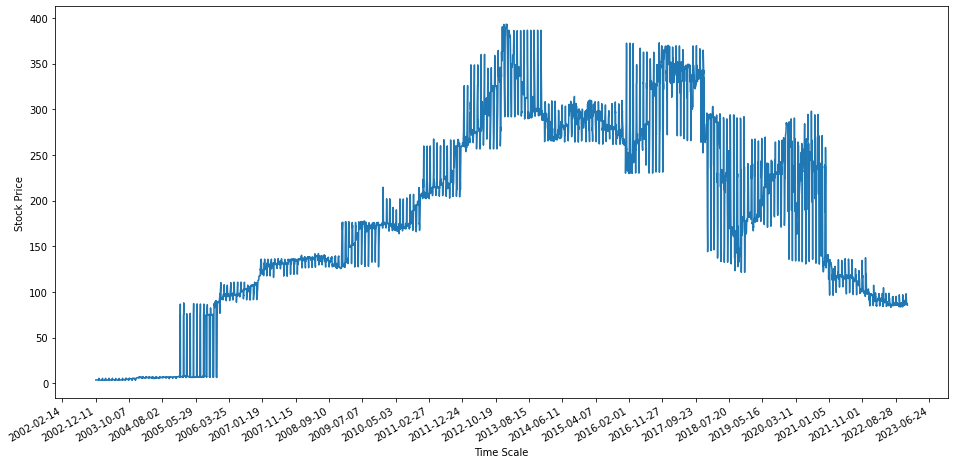

In [7]:
plt.figure(figsize=(16,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=300))
plt.xlabel('Time Scale')
plt.ylabel('Stock Price')
plt.plot(df.index,df['Stock Price'])
plt.gcf().autofmt_xdate()
plt.show()

In [8]:
data=df.filter(['Stock Price'])
dataset=data.values
training_data_length = math.ceil(len(dataset)*.8)
training_data_length
dataset.shape

(5218, 1)

In [9]:
#Normalization of data - feature scaling 
sc=MinMaxScaler(feature_range=(0,1))
df_scaled=sc.fit_transform(df.values)
scaled_data = pd.DataFrame(df_scaled,columns=df.columns,index=df.index)

In [10]:
#create the training data set 
train_data = df_scaled[0:training_data_length,:]

#splits the data into x_train and y_train
x_train=[]
y_train=[]

for i in range(1103,len(train_data)):
  x_train.append(train_data[i-1103:i,0])
  y_train.append(train_data[i,0])

In [11]:
#convert the x and y train into numpy arrays
x_train , y_train = np.array(x_train),np.array(y_train)

In [12]:
#reshape the data (lstm model accepts 3 dimensional data)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(3072, 1103, 1)

In [13]:
#build the lstm model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
#compile the model 
model.compile(optimizer='adam',loss='mean_squared_error')

In [23]:
#train the model
model.fit(x_train,y_train,batch_size=32,epochs=15)

Epoch 1/15
96/96 [==============================] - 47s 492ms/step - loss: 0.0017
Epoch 2/15
96/96 [==============================] - 48s 495ms/step - loss: 0.0017
Epoch 3/15
96/96 [==============================] - 48s 502ms/step - loss: 0.0018
Epoch 4/15
96/96 [==============================] - 48s 495ms/step - loss: 0.0017
Epoch 5/15
96/96 [==============================] - 48s 496ms/step - loss: 0.0018
Epoch 6/15
96/96 [==============================] - 48s 499ms/step - loss: 0.0017
Epoch 7/15
96/96 [==============================] - 49s 506ms/step - loss: 0.0017
Epoch 8/15
96/96 [==============================] - 47s 493ms/step - loss: 0.0018
Epoch 9/15
96/96 [==============================] - 47s 490ms/step - loss: 0.0017
Epoch 10/15
96/96 [==============================] - 47s 492ms/step - loss: 0.0017
Epoch 11/15
96/96 [==============================] - 48s 502ms/step - loss: 0.0018
Epoch 12/15
96/96 [==============================] - 47s 489ms/step - loss: 0.0018
Epoch 13/15
9

In [24]:
 #create the testing dataset
#arrays contains scaled value from 4115 to 5218
test_data=df_scaled[training_data_length-1103:, :]
#create the dataset X_test and y_test 
x_test=[]
y_test=dataset[training_data_length:, :]
for i in range(1103 ,len(test_data)):
  x_test.append(test_data[i-1103:i,0])

In [25]:
#convert the data into numpy array
x_test=np.array(x_test)

In [26]:
#reshape the data 
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [27]:
#get the model's predicted price values
prediction = model.predict(x_test)
prediction = sc.inverse_transform(prediction) #unscaling the values

33/33 [==============================] - 5s 143ms/step


In [28]:
#evaluation of model 
#get the root mean squared error
rmse=np.sqrt(np.mean(prediction-y_test)**2)
rmse


0.5549755740581747

<ipython-input-29-e68a157e0b5b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['prediction']=prediction


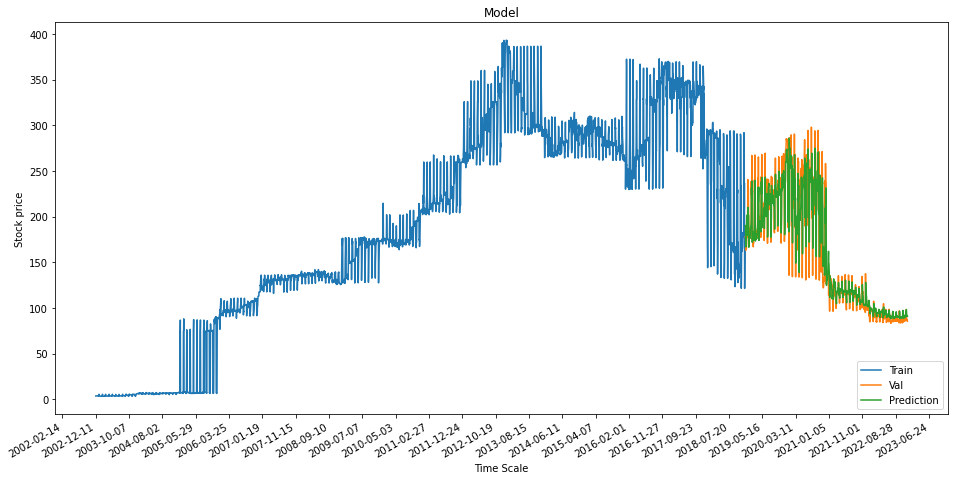

In [29]:
#plot the data 
train = df[:training_data_length]
valid = df[training_data_length:]
valid['prediction']=prediction

#visualize the data 
plt.figure(figsize=(16,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=300))
plt.title('Model')
plt.xlabel('Time Scale')
plt.ylabel('Stock price')
plt.plot(train['Stock Price'])
plt.plot(valid[['Stock Price','prediction']])
plt.legend(['Train','Val','Prediction'],loc='lower right')
plt.gcf().autofmt_xdate()
plt.show()

In [30]:
valid.head(20)

,Stock Price,prediction
Date,,
2018-12-14,177.934000,190.083786
2018-12-17,177.633333,189.266449
2018-12-18,174.476667,184.371582
2018-12-19,171.737333,177.418884
2018-12-20,163.186000,172.278076
2018-12-21,164.888667,166.801910
2018-12-24,164.888667,170.036057
2018-12-25,164.888667,175.787750
2018-12-26,169.747333,182.347549


ARIMA model

In [11]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.8 MB/s 
     |████████████████████████████████| 9.9 MB 64.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [33]:
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

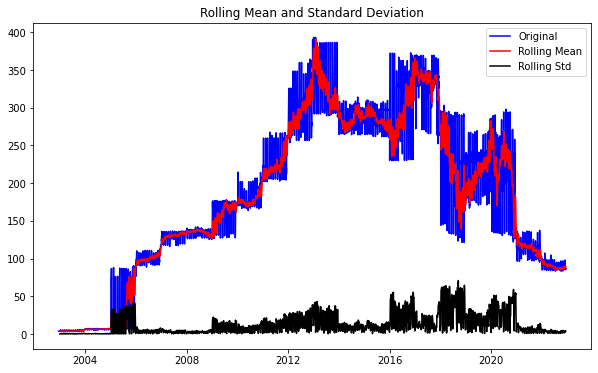

Results of dickey fuller test
Test Statistics                  -1.484740
p-value                           0.541047
No. of lags used                 30.000000
Number of observations used    5187.000000
critical value (1%)              -3.431611
critical value (5%)              -2.862097
critical value (10%)             -2.567067
dtype: float64


In [34]:
#test for stationarity 
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(data)

Increasing mean and standard deviation in the above graph represents that our data is not stationary.

<Figure size 720x432 with 0 Axes>

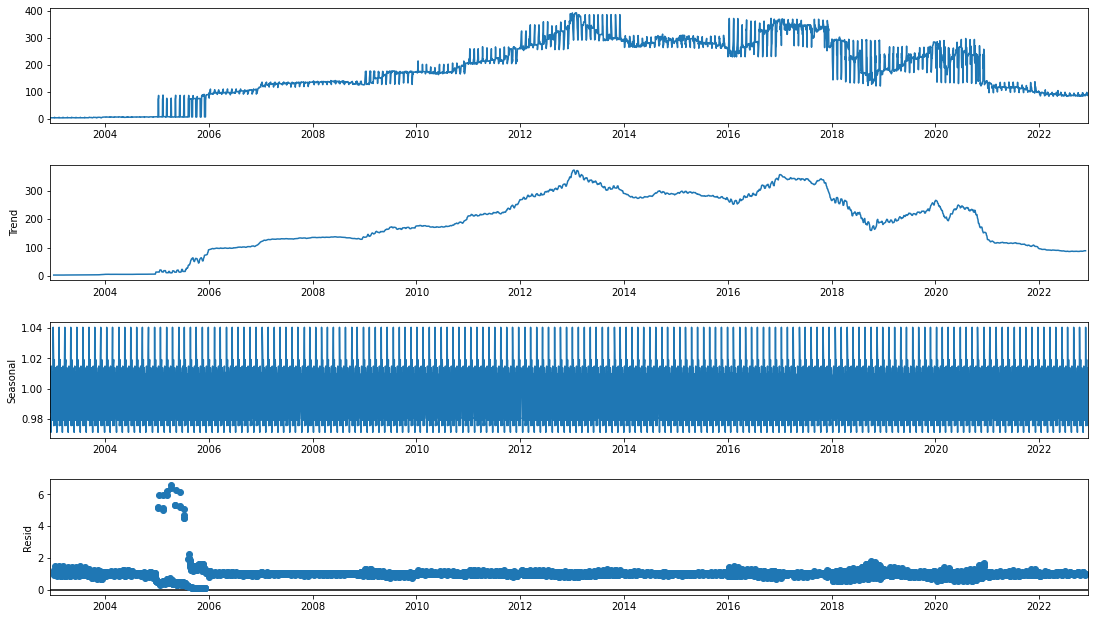

In [35]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(data, model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

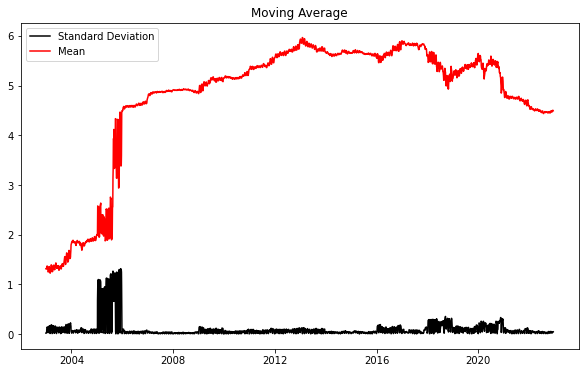

In [36]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

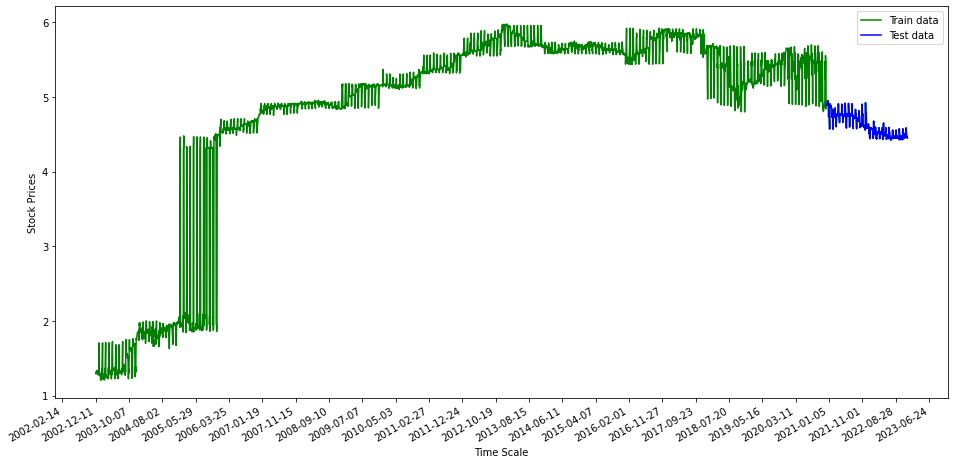

In [37]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(False)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=300))
plt.xlabel('Time Scale')
plt.ylabel('Stock Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.gcf().autofmt_xdate()
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1978.842, Time=1.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1979.993, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1980.808, Time=3.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1980.773, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2569.892, Time=6.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2668.289, Time=4.89 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2021.810, Time=3.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2705.197, Time=6.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2219.522, Time=4.88 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2702.680, Time=8.63 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2601.866, Time=7.81 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-2701.053, Time=2.07 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 49.298 seconds
                               SARIMAX Results                             

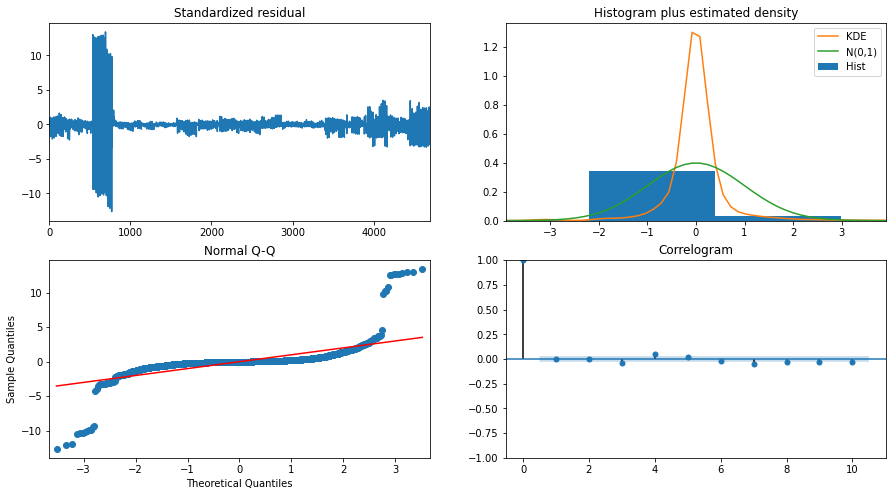

In [29]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [39]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(3,1,1))  
fitted = model.fit()  
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:            Stock Price   No. Observations:                 4693
Model:                 ARIMA(3, 1, 1)   Log Likelihood                1355.526
Date:                Mon, 26 Dec 2022   AIC                          -2701.053
Time:                        00:53:40   BIC                          -2668.784
Sample:                             0   HQIC                         -2689.707
                               - 4693                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7762      0.009     83.178      0.000       0.758       0.795
ar.L2         -0.0780      0.010     -8.159      0.000      -0.097      -0.059
ar.L3         -0.0933      0.004    -25.808      0.0

In [83]:
# Forecast
fc= fitted.forecast(522, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.DataFrame(fc.values,columns=test_data.columns ,index=test_data.index)

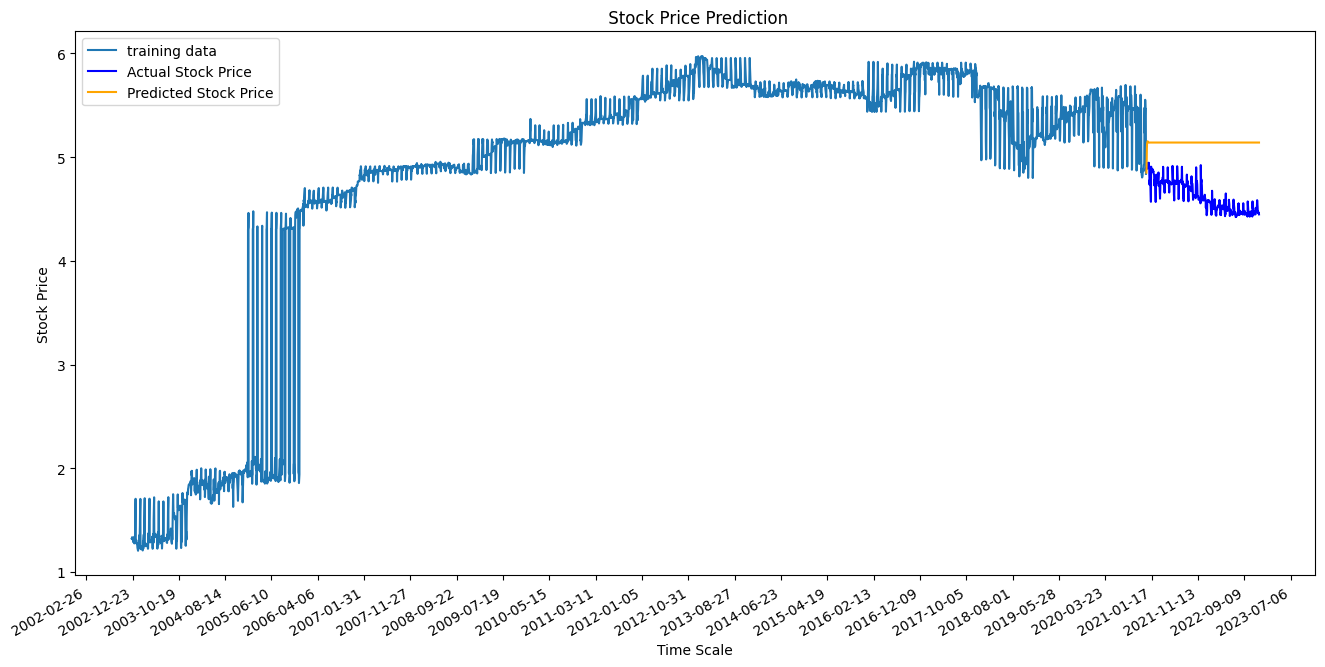

In [86]:
# Plot
plt.figure(figsize=(16,8), dpi=100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=300))
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time Scale')
plt.ylabel('Stock Price')
plt.gcf().autofmt_xdate()
plt.legend()

In [90]:
# report performance
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

RMSE: 0.5391552226850972


1- RMSE of LSTM model = 0.5549755740581747                   
2- RMSE of ARIMA model = 0.5391552226850972